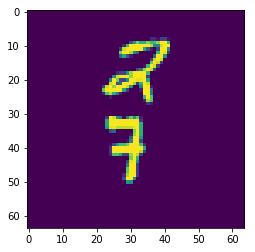

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import urllib.request
import os.path
import numpy as np
import sys
sys.path.insert(0, './')
from utils import plot_mats
from pgpnn import ImageSplitter, PredictiveGatingPyramid

file_name = 'mnist_test_seq.npy'
url = 'http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy'

if not os.path.isfile(file_name):
    print("could not find dataset: download it..")
    urllib.request.urlretrieve(url, file_name)
    print("download complete")

# Moving Mnist: 10.000 sequences of length 20 showing 2 digits moving in 64x64
moving_mnist = np.load(file_name) # shape: 20,10000,64,64
moving_mnist = np.rollaxis(moving_mnist, 1) # --> 10000,20,64,64

plt.imshow(moving_mnist[0,0])
plt.show()

In [2]:
model = PredictiveGatingPyramid(depth=2, modelname='test_pgp')
history = model.train(
    moving_mnist,
    epochs=200,
    learningRate=0.00001,
    save_results=True,
    load_stages=True)

plt.plot(range(0, len(history)), history)
plt.show()

[CONSTRUCT LAYER 1]
	pre-loading weights for Layer 1
[CONSTRUCT LAYER 2]
	pre-loading weights for Layer 2
Training: Epoch: 001/200 cost: 673.624885110 time: 22.93
Training: Epoch: 002/200 cost: 676.104607077 time: 21.74
Training: Epoch: 003/200 cost: 677.714269301 time: 21.74
Training: Epoch: 004/200 cost: 680.059168199 time: 21.72
Training: Epoch: 005/200 cost: 680.885742188 time: 21.79
Training: Epoch: 006/200 cost: 681.717601103 time: 21.77
Training: Epoch: 007/200 cost: 683.886488971 time: 21.65
Training: Epoch: 008/200 cost: 683.870978860 time: 21.69
Training: Epoch: 009/200 cost: 685.928423713 time: 21.81


KeyboardInterrupt: 

In [ ]:
a = moving_mnist[0,0]
b = moving_mnist[0,1]
c = moving_mnist[0,2]
im = model.predict(a,b,c)

In [ ]:
fig = plt.figure(figsize=(16,4))
fig.add_subplot(141).imshow(a)
fig.add_subplot(142).imshow(b)
fig.add_subplot(143).imshow(c)
fig.add_subplot(144).imshow(im)

In [ ]:
# print(model.V1_np.shape)
# print(model.U1_np.shape)

# import matplotlib.pyplot as plt
# import pylab

# # function copied from the original code
# def dispims(M, height, width, border=0, bordercolor=0.0, layout=None, **kwargs):
#     from pylab import cm, ceil
#     numimages = M.shape[1]
#     if layout is None:
#         n0 = int(np.ceil(np.sqrt(numimages)))
#         n1 = int(np.ceil(np.sqrt(numimages)))
#     else:
#         n0, n1 = layout
#     im = bordercolor * np.ones(((height+border)*n0+border,(width+border)*n1+border),dtype='<f8')
#     for i in range(n0):
#         for j in range(n1):
#             if i*n1+j < M.shape[1]:
#                 im[i*(height+border)+border:(i+1)*(height+border)+border,
#                    j*(width+border)+border :(j+1)*(width+border)+border] = np.vstack((
#                             np.hstack((np.reshape(M[:,i*n1+j],(height, width)),
#                                    bordercolor*np.ones((height,border),dtype=float))),
#                             bordercolor*np.ones((border,width+border),dtype=float)
#                             ))
    
#     return im


# I = dispims(model.U1_np, 64, 64, 10)
# J = dispims(model.V1_np, 64, 64, 10)

# fig = plt.figure(figsize=(16,8))
# fig.add_subplot(121).imshow(I)
# fig.add_subplot(122).imshow(J)

# plt.show()